##  Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.   

Построим модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.  

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Описание данных:**

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)

## Изучение данных

In [ ]:
#!pip install sweetviz --quiet

In [ ]:
#!pip install catboost --quiet

In [ ]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import *
from sklearn.model_selection import * #train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from catboost import CatBoostRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model#LinearRegression

import time

import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

In [ ]:
try:
  !gdown --id 1bOjvTYUn4WfeX1OewWdOtiP9FTNQGn9O --quiet
  df = pd.read_csv('autos.csv')
except:
  df = pd.read_csv('/datasets/autos.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем названия колонок к стилю snake_case.

In [ ]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Посмотрим на состав наших данных.

[Отчет](https://drive.google.com/file/d/1G9TtUvM89LWeQunmUjpiUzNPs7lq4JaV/view?usp=sharing)

In [ ]:
#report_0 = sv.analyze([df, 'Авто'])
#report_0.show_html()

Удалим 4 **дубликата**.

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(354365, 16)

В колонке с годом регистрации(**`registration_year`**) есть аномальные значения(минимуму 1000, максимум 9999), мы удалим года меньше 1930 и больше 2022, так как год регистрации может влиять на цену.  

В колонке с месяцем регистрации(**`registration_month`**) есть значение 0, что не соответствует реальности, но эту колонку мы тоже удалим. 

Мощность(**`power`**) в наших данных тоже есть аномальная. Мы будем считать, что максимальная возможная мощность 1 600 л.с. Тогда все, что выше будем считать ошибкой в данных, поэтому изменим на диапазон значений между первым и третьим квартилем. Так же там 11% от всех данных нули, видимо значения не заполняли и проставились нули. Тоже заменим.  

В цене(**`price`**) 10 772 нулевых значений. Так как нам необходимо предсказать стоимость, то эти значения удалим, так как нулевой ценник скорее всего ставят для обмена или если машина не на ходу.

### Неинформативные колонки

Информация о датах создания анкеты(`data_crawled`), месяц регистрации(`registration_month`), дата создания анкеты(`date_created`), количество фотографий(`number_of_pictures`), дата последней активности(`last_seen`), почтовый индекс(`postal_code`) для построения модели нам не нужны, удалим их.

In [ ]:
data = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures',\
                'postal_code', 'last_seen'], axis=1)

### Аномалии

**Год регистрации.**

Оставим года с 1930 по 2016(так как максимальный год - год скачивания анкеты).

In [ ]:
data = data.loc[(data['registration_year'] > 1930) & (data['registration_year'] < 2016)]

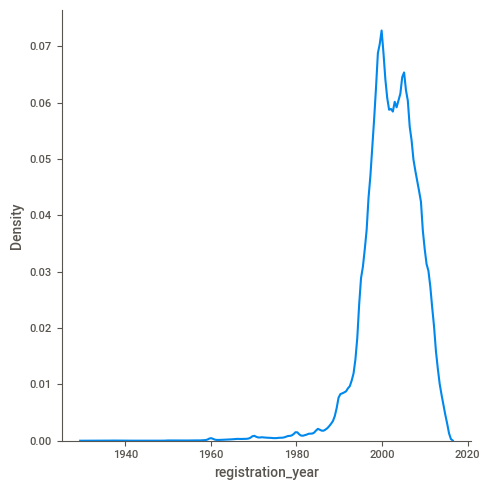

In [ ]:
sns.displot(data, x="registration_year", kind="kde")

**Мощность.**

In [ ]:
data['power'].describe()

count    330050.000000
mean        111.931786
std         182.424458
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Значения мощности, которые больше 1600 и которые меньше 16 л.с., заменим случайными числами от 69 до 143, где находится основной диапазон значений.

In [ ]:
def power(row):
  if row > 1600 or row < 16:
    row = random.randint(69, 143)
  return row

In [ ]:
data['power'] = data['power'].apply(power)

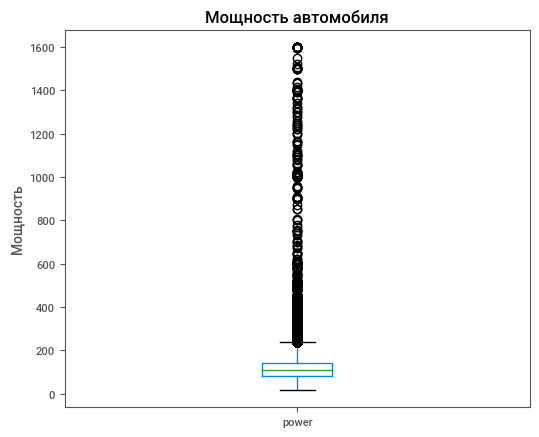

In [ ]:
data.boxplot('power', figsize=(6,5), grid=False)
plt.title('Мощность автомобиля')
plt.ylabel('Мощность')
plt.show()

In [ ]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,94,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


**Цена**

**`price`**  
В колонке цены есть аномально низкие цены. Скорее всего такие объявления выставлены на обмен, либо машина не на ходу или битая. Так как нам нужно предсказать рыночную стоимость, то такие объявления мы рассматривать не будем.  

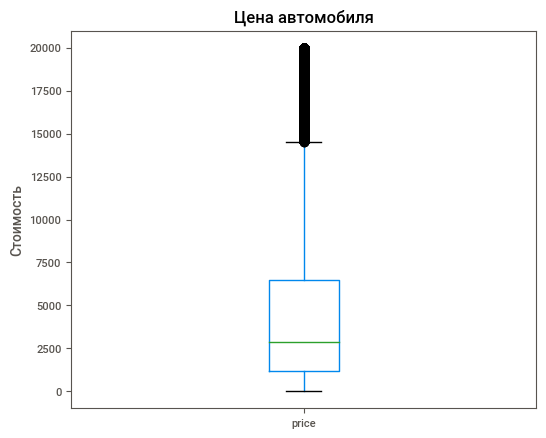

In [ ]:
data.boxplot('price', figsize=(6,5), grid=False)
plt.title('Цена автомобиля')
plt.ylabel('Стоимость')
plt.show()

In [ ]:
data['price'].describe()

count    330050.000000
mean       4541.211626
std        4564.258474
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Отберем только те объявления, которые больше 100 евро.

In [ ]:
data = data.loc[data['price'] > 100]

### Пропуски

In [ ]:
data.isna().sum()

price                    0
vehicle_type          9929
registration_year        0
gearbox              13169
power                    0
model                13832
kilometer                0
fuel_type            19417
brand                    0
repaired             53895
dtype: int64

**`repaired`**  
Если не указано была ли машина в ремонте или нет, то будем считать, что нет. Потому что если бы была, это указали бы, а так могли забыть.  

In [ ]:
data.loc[data['repaired'].isna(), 'repaired'] = 'no'

In [ ]:
data['repaired'].isna().sum()

0

In [ ]:
data['repaired'].unique()

array(['no', 'yes'], dtype=object)

**`vehicle_type`**  
Неизвестные типы кузовов заменим на значение `other`.

In [ ]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
data.loc[data['vehicle_type'].isna(), 'vehicle_type'] = 'other'

In [ ]:
data['vehicle_type'].isna().sum()

0

**`fuel_type`**  
Пропуски здесь тоже заполним значением `other`.

In [ ]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
data.loc[data['fuel_type'].isna(), 'fuel_type'] = 'other'

In [ ]:
data['fuel_type'].isna().sum()

0

**`model`**  
Модель машины напрямую влияет на цену, поэтому заменять на какие-либо значения будет неправильно, поэтому удалим пропуски.

In [ ]:
data.dropna(subset=['model'], inplace=True)
data['model'].isna().sum()

0

**`gearbox`**  
Тип коробки передач может сильно влиять на ценник, поэтому лучше удалить пустые значения, во избежания "шума" в данных.

In [ ]:
data.dropna(subset=['gearbox'], inplace=True)

In [ ]:
data['gearbox'].isna().sum()

0

In [ ]:
data['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292616 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              292616 non-null  int64 
 1   vehicle_type       292616 non-null  object
 2   registration_year  292616 non-null  int64 
 3   gearbox            292616 non-null  object
 4   power              292616 non-null  int64 
 5   model              292616 non-null  object
 6   kilometer          292616 non-null  int64 
 7   fuel_type          292616 non-null  object
 8   brand              292616 non-null  object
 9   repaired           292616 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


In [ ]:
print(f'Удалили {round(1 - data.shape[0] / df.shape[0], 1) * 100}% данных')

Удалили 20.0% данных


Посмотрим корреляцию числовых признаков.

<AxesSubplot:>

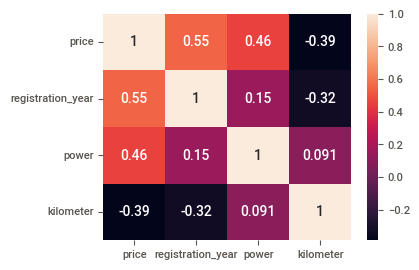

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(data.corr(), annot=True)

### Вывод

**Итак,** мы оставили 9 признаков, определяющие цену автомобиля, по которым будем строить модели машинного обучения. Числовых значений у нас всего 3, при этом большой разброс значений. Остальные признаки - категориальные, мы будем использовать порядковое кодирование.  
Наблюдается сильная положительная зависимость между мощностью автомоболя и его стоимостью. Также стоимость сильно зависит от года регистрации. Отрицательная корреляция между пробегом и ценой, что логично.

## Подготовим выборки для обучения моделей

Разделим на признаки и целевой показатель.


In [ ]:
features = data.drop(['price'], axis=1)
target = data['price']

In [ ]:
features_train, features_test, target_train, target_test \
= train_test_split(features, target, test_size=0.25, random_state=12345)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((219462, 9), (73154, 9), (219462,), (73154,))

Произведем порядковое кодирование.

In [ ]:
cat_columns = ['vehicle_type', 'model', 'gearbox', 'repaired', 'fuel_type', 'brand']

In [ ]:
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

Масштабируем данные.

In [ ]:
num = ['kilometer', 'model', 'registration_year','power', 'brand']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ord[num])

features_train_ord[num] = scaler.transform(features_train_ord[num])
features_test_ord[num] = scaler.transform(features_test_ord[num])

In [ ]:
features_train_ord.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
278166,5.0,1.369457,1.0,0.014686,-1.163773,-1.326230,6.0,-1.485741,0.0
59690,6.0,-0.571372,1.0,-0.719608,0.231246,0.588587,6.0,1.048229,0.0
137289,5.0,-1.218315,1.0,-0.090213,0.104426,0.588587,6.0,1.278590,0.0
20007,2.0,1.692929,1.0,0.609115,0.808981,-2.693957,6.0,0.357146,0.0
129600,5.0,-0.409636,0.0,-0.579742,-0.036485,-0.095276,6.0,0.894655,0.0


## Обучение моделей

Для оценки качества модели будем использовать метрику RMSE.

In [ ]:
def rmse_metric(target, predictions):
  return (mean_squared_error(target, predictions) ** 0.5).round(2)

In [ ]:
rmse_scorer = make_scorer(rmse_metric, greater_is_better = False)

### Дерево решений

Подбор параметров.

In [ ]:
dtr = DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range (1, 13, 2), 
             'min_samples_leaf': range (1, 8),
             'min_samples_split': range (2, 11, 2)}

model_dtr = GridSearchCV(dtr, parametrs, scoring=rmse_scorer, cv=5)
model_dtr.fit(features_train_ord, target_train)

model_dtr.best_params_

{'max_depth': 11, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [ ]:
rmse_d = abs(model_dtr.best_score_)
rmse_d

1905.39

In [ ]:
res_dtr = pd.DataFrame(model_dtr.cv_results_)
res_dtr.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
205,0.403800,0.002376,0.008448,0.000503,11,7,2,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",-1897.5,-1909.78,-1897.72,-1922.98,-1900.09,-1905.614,9.773437,6
206,0.414368,0.015533,0.008606,0.000360,11,7,4,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",-1897.5,-1909.78,-1897.72,-1922.98,-1900.09,-1905.614,9.773437,6
207,0.400235,0.005739,0.008376,0.000227,11,7,6,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",-1897.5,-1909.78,-1897.72,-1922.98,-1900.09,-1905.614,9.773437,6
208,0.411295,0.014535,0.008709,0.000271,11,7,8,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",-1897.5,-1909.78,-1897.72,-1922.98,-1900.09,-1905.614,9.773437,6
209,0.492243,0.082157,0.009955,0.001469,11,7,10,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",-1897.5,-1909.78,-1897.72,-1922.98,-1900.09,-1905.614,9.773437,6


In [ ]:
start = time.time()

model_dtr.best_estimator_.predict(features_train_ord)

end = time.time()

Сохраним лучшее время обучения и предсказания модели дерева решений.

In [ ]:
t_model = {}
t_model['fit_dtr'] = round(sum(res_dtr['mean_fit_time']), 2)
t_model['pred_dtr'] = round(end - start, 2)
t_model

{'fit_dtr': 55.5, 'pred_dtr': 0.04}

### Линейная регрессия

In [ ]:
start = time.time()

lr = linear_model.RidgeCV(scoring=rmse_scorer)
lr.fit(features_train_ord, target_train)

end = time.time()
t_model['fit_lr'] = round(end - start, 2)

In [ ]:
start = time.time()

prediction_lr = lr.predict(features_train_ord)

end = time.time()
t_model['pred_lr'] = round(end - start, 2)

In [ ]:
rmse_lr = abs(lr.best_score_)
rmse_lr

3009.78

Text(0.5, 0.98, 'Линейная регрессия')

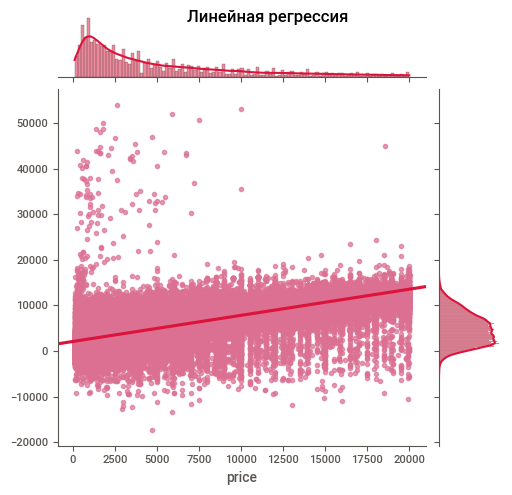

In [ ]:
sns.jointplot(x=target_train, y=prediction_lr,
                  kind="reg", truncate=False,
                  color="crimson",joint_kws = {'scatter_kws':dict(alpha=0.7, color='palevioletred')}, height=5)
plt.suptitle('Линейная регрессия')

In [ ]:
t_model

{'fit_dtr': 55.5, 'pred_dtr': 0.04, 'fit_lr': 0.37, 'pred_lr': 0.01}

### Catboost

In [ ]:
start = time.time()

model_cb = CatBoostRegressor(loss_function='RMSE',learning_rate=0.4, iterations=1000)
model_cb.fit(features_train, target_train, cat_features=cat_columns, verbose=200)

end = time.time()
t_model['fit_cb'] = round(end - start, 2)

0:	learn: 3434.8452820	total: 362ms	remaining: 6m 1s
200:	learn: 1526.0283623	total: 42.4s	remaining: 2m 48s
400:	learn: 1465.3981344	total: 1m 33s	remaining: 2m 19s
600:	learn: 1430.8791229	total: 2m 8s	remaining: 1m 25s
800:	learn: 1405.1376168	total: 2m 47s	remaining: 41.5s
999:	learn: 1385.3752007	total: 3m 24s	remaining: 0us


In [ ]:
rmse_cb = round(model_cb.best_score_.get('learn').get('RMSE'),2)
rmse_cb

1385.38

In [ ]:
start = time.time()

prediction_cb = model_cb.predict(features_train)

end = time.time()
t_model['pred_cb'] = round(end - start, 2)

### LightGBM 

In [ ]:
start = time.time()

model_lgbm = lgbm.sklearn.LGBMRegressor(n_estimators=1000,  random_state=12345, learning_rate=0.4, objective='rmse')
model_lgbm.fit(features_train_ord, target_train)

end = time.time()
t_model['fit_lgbm'] = round(end - start, 2)

In [ ]:
start = time.time()

prediction_lgbm = model_lgbm.predict(features_train_ord)

end = time.time()
t_model['pred_lgbm'] = round(end - start, 2)


In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=12345)
n_scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_scorer, cv=cv)

rmse_lgbm = round(abs(np.mean(n_scores)), 2)
rmse_lgbm

1527.2

### Проанализируем время обучения, время предсказания и качество моделей

In [ ]:
t_model

{'fit_dtr': 55.5,
 'pred_dtr': 0.04,
 'fit_lr': 0.37,
 'pred_lr': 0.01,
 'fit_cb': 206.47,
 'pred_cb': 3.09,
 'fit_lgbm': 10.28,
 'pred_lgbm': 9.69}

In [ ]:
d = {'time_fit':[t_model.get('fit_dtr'), t_model.get('fit_lr'), t_model.get('fit_cb'), t_model.get('fit_lgbm')],\
     'time_pred':[t_model.get('pred_dtr'), t_model.get('pred_lr'), t_model.get('pred_cb'), t_model.get('pred_lgbm')],\
     'RMSE':[rmse_d, rmse_lr, rmse_cb, rmse_lgbm]}
answer = pd.DataFrame(data =d, index=['DecisionTreeRegressor','LinearRegression', 'CatBoostRegressor',\
                                      'LGBMRegressor'])
answer

,time_fit,time_pred,RMSE
DecisionTreeRegressor,55.50,0.04,1905.39
LinearRegression,0.37,0.01,3009.78
CatBoostRegressor,206.47,3.09,1385.38
LGBMRegressor,10.28,9.69,1527.20


**Итак,** обучили четыре модели, пришли к таким результатам:
* самая быстрая модель - линейная регрессия, но качество ее - самое низкое;
* лучшее качество показала модель `CatBoostRegressor` - 1385, но время обучения модели 3,5 минуты;
* достаточно хорошее качество предсказания показала модель `LGBMRegressor` 1527, и время обучения и предсказания около 10 секунд;
* дерево решений обучалось 55 секунд, а RMSE = 1905.  

Нам важно и время обучения и качество предсказания, поэтому на тестовой выборке проверим модель `LGBMRegressor`.

## Тестирование лучшей модели

Возьмем обученную модель `model_lgbm` и рассчитаем метрику RMSE.

In [ ]:
print(f'Значение метрики RMSE на test: {rmse_metric(target_test, model_lgbm.predict(features_test_ord))}')

Значение метрики RMSE на test: 1512.56


## Вывод

Задачей было построить модель, которая предсказывала бы рыночную стоимость автомобиля по данным характеристикам.  
В данных были обработаны аномалии и пропуски. Выбраны информативные колонки для построения модели.  
Для использования линейной регрессии, дерева решений и `LightGBM` произведено кодирование признаков с помощью `OrdinalEncoder`. Так же произведено масштабирование признаков.  

**Вывод по моделям:**
* `LinearRegression` - очень низкое качество - 3009, но самое быстрое обучение 0.37 секунд;
* `DecisionTreeRegressor` - обучение меньше минуты, RMSE = 1905;
* `CatBoostRegressor` имеет самое высокое качество(1385), но и обучение самое продолжительное (3.5 минуты);
* `LGBMRegressor` учится и предсказывает примерно за 10 секунд, при этом качество 1527.  

Для тестирования выбрана модель `LGBMRegressor`, так как у нее и качество соответствует требованиям и скорость обучения относительно недолгая.
На тестовой выборке значение RMSE = 1512, что удовлетворяет условиям.

**Рекомендации:** для предсказания стоимости автомобиля по ее характеристикам рекомендую выбирать модель `LGBMRegressor`. Эта модель показала высокое качество и обучается достаточно быстро. 